In [1]:
import sqlite3
import os
from skimage.feature import register_translation
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
from ginga.util import iqcalc
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit

In [2]:
# import LAM library for logbook, data analysis...
from Lib_PFS_LAM import *

In [3]:
imgPath = '/home/pfs/shared/Pictures/SM1'

In [4]:
smId = 1

In [5]:
# filepath of data model
pmodel = '/home/pfs/dev/ait-notebook/optical/input/slit'
file = 'slit-defParam-Ouverture100-fiber65.csv'

In [6]:
zemaxData = pd.read_csv('%s/%s'%(pmodel, file), delimiter=" ")
zemaxMidFit = fitparabola(x=zemaxData.Slitdefocus, y=zemaxData.MidFiber, deg=15, focus='max')
zemaxEndFit = fitparabola(x=zemaxData.Slitdefocus, y=zemaxData.ExtremeFiber, deg=15, focus='max')

In [7]:
def getFiberPeak(filelist, ind, duplicate, doMeanBck, crit, radius=60, threshold=1000):
    calc = iqcalc.IQCalc(None)
    hdr, data = stackedImage(filelist=filelist, ind=ind, duplicate=duplicate, doMeanBck=doMeanBck)
    fca_x = hdr['FCA_X']

    peaks = calc.find_bright_peaks(data, threshold=threshold, radius=radius)

    objlist = calc.evaluate_peaks(peaks, data, fwhm_radius=radius, cb_fn=None, ev_intr=None, fwhm_method='gaussian')
    objlist = [ elem for elem in objlist if elem['fwhm'] > 15]
    objlist = [ elem for elem in objlist if 1000<elem['brightness']<50000]
    if not objlist:
        raise ValueError('peak has not been properly detected')

    for peak in objlist:
        peak['fca_x'] = fca_x
        peak['EE'] = getEE(peak=peak, image=data, inner_size=20, outer_size=150)
        peak['flux_EE'] = np.sum(data)
        # center of mass
        peak['com_EE'] = getEE(peak=peak, image=data, inner_size=20, outer_size=150, com=True)
        
    maxi = np.argmax([obj[crit] for obj in objlist])
    peak = objlist[maxi]
    
    return peak


def getFiberTF(experimentId, doMeanBck, centerOfMass):
    
    visitStart, visitEnd = Logbook.visitRange(experimentId=experimentId)
    filelist = constructFilelist(visitStart=visitStart, visitEnd=visitEnd)    
    fibername = Logbook.getParameter(experimentId=experimentId, param='fiber')
    duplicate = int(Logbook.getParameter(experimentId=experimentId, param='duplicate'))
    dateobs = getDateObs(experimentId=experimentId)
    
    description = pd.DataFrame([(experimentId, dateobs, len(filelist), visitStart, visitEnd, fibername, duplicate)], 
                               columns=['experimentId', 'dateobs', 'nbImages', 'visitStart','visitEnd','fiber','duplicate'])

    crit = 'com_EE' if centerOfMass else 'EE'
    res = []
    
    for i in range(len(filelist)//duplicate):
        try:
            fiberPeak = getFiberPeak(filelist, ind=i, duplicate=duplicate, 
                                     doMeanBck=doMeanBck, 
                                     crit=crit)
            res.append(tuple(list(fiberPeak.values())))

        except ValueError:
            pass
    
    return description, crit, pd.DataFrame(res, columns=list(fiberPeak.keys()))   

## Data required : 
To be able to find the right focus, some data acquisition is required.

you need to use ics_spsaitActor to perform your sequence

example : <b>slit throughfocus exptime=6.0 lowBound=-0.5 upBound=1.5 fiber=engbotend nbPosition=10 duplicate=1 </b>

-0.5 : 1.5 is the range of the slit focus


## Input Parameters : 
The only parameters needed is the experimentIds that match your data acquisition sequence

In [8]:
centerOfMass = True
doMeanBck = True
experimentId = 107 #the first experimentId is 12

In [9]:
description, crit, raw_df = getFiberTF(experimentId=experimentId, doMeanBck=doMeanBck, centerOfMass=centerOfMass)

/software/conda/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


In [10]:
description.set_index('experimentId')

,dateobs,nbImages,visitStart,visitEnd,fiber,duplicate
experimentId,,,,,,
107,2018-08-01T22:56:18,50,4813,4862,engtopmid,1


In [11]:
lneg = 5
lpos = -1

In [12]:
df = raw_df[lneg:lpos]

In [13]:
fit_EE = fitparabola(x=df['fca_x'], y=df[crit], deg=15, focus='max')

In [14]:
if 'mid' in description.fiber[0]:
    zemaxRawData = zemaxData.MidFiber 
    zemaxFit = zemaxMidFit
else:
    zemaxRawData = zemaxData.ExtremeFiber
    zemaxFit = zemaxEndFit

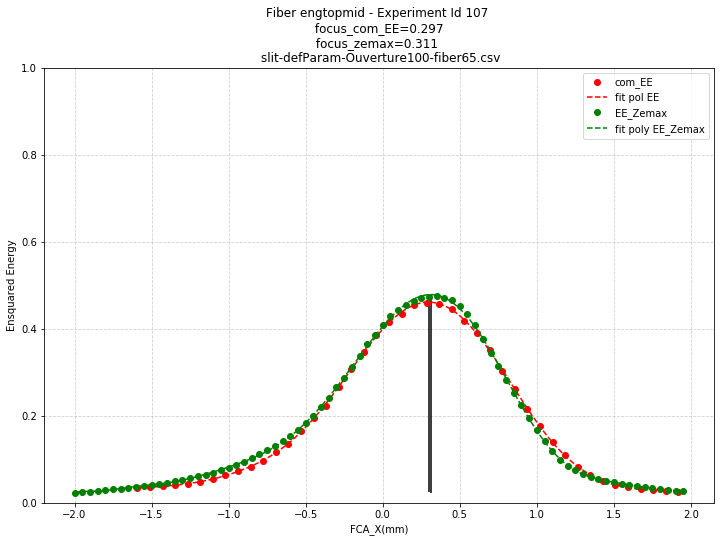

In [15]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(111)

ax1.set_xlabel('FCA_X(mm)')
ax1.set_ylabel('Ensquared Energy')

ax1.plot(df['fca_x'], df[crit], 'ro', label=crit)
ax1.plot(fit_EE.x, fit_EE.y, 'r--', label='fit pol EE')
ax1.vlines(**fit_EE.vline)

ax1.plot(zemaxData.Slitdefocus, zemaxRawData, 'go', label='EE_Zemax')
ax1.plot(zemaxFit.x, zemaxFit.y, 'g--', label='fit poly EE_Zemax')
ax1.vlines(**zemaxFit.vline)


plt.title('Fiber %s - Experiment Id %i \n focus_%s=%.3f \n focus_zemax=%.3f  \n %s' %(description.fiber[0], 
                                                                                      experimentId,  
                                                                                      crit,
                                                                                      fit_EE.focus,
                                                                                      zemaxFit.focus, 
                                                                                      file))

plt.legend()
ax1.grid(which='major', alpha=0.6, linestyle='--')
ax1.set_ylim(0,1)

doSave=False

if doSave:
    filename = 'SM1_SLITALIGN_Model_EXP%i_Fiber%s'%(experimentId,description.fiber[0])
    filename +=('_bck' if doMeanBck else '')
    filename +='_%s.png'%crit
    plt.savefig(os.path.join(imgPath, filename))
    